In [2]:
import pandas as pd
from prophet import Prophet


train_df = pd.read_csv('2022-2023_booking.csv')
test_df = pd.read_csv('test_data_2024.csv')


ข้อมูลฝึกฝน:
          ds     y
0 2022-01-01  1.00
1 2022-01-02  1.00
2 2022-01-03  0.38
3 2022-01-04  0.38
4 2022-01-05  0.00

ข้อมูลทดสอบ:
          ds     y
0 2024-01-01  0.00
1 2024-01-02  0.00
2 2024-01-03  0.00
3 2024-01-04  0.12
4 2024-01-05  0.25

ความถี่ของข้อมูลฝึกฝน: D
SARIMAX(0, 0, 0)x(0, 0, 0, 7) - MAPE: 100.00%
SARIMAX(0, 0, 0)x(0, 0, 1, 7) - MAPE: 98.09%
SARIMAX(0, 0, 0)x(1, 0, 0, 7) - MAPE: 97.03%
SARIMAX(0, 0, 0)x(1, 0, 1, 7) - MAPE: 81.65%
SARIMAX(0, 0, 1)x(0, 0, 0, 7) - MAPE: 100.00%
SARIMAX(0, 0, 1)x(0, 0, 1, 7) - MAPE: 98.40%
SARIMAX(0, 0, 1)x(1, 0, 0, 7) - MAPE: 97.67%
SARIMAX(0, 0, 1)x(1, 0, 1, 7) - MAPE: 82.13%
SARIMAX(0, 0, 2)x(0, 0, 0, 7) - MAPE: 100.00%
SARIMAX(0, 0, 2)x(0, 0, 1, 7) - MAPE: 98.54%
SARIMAX(0, 0, 2)x(1, 0, 0, 7) - MAPE: 97.91%
SARIMAX(0, 0, 2)x(1, 0, 1, 7) - MAPE: 84.02%
SARIMAX(0, 1, 0)x(0, 0, 0, 7) - MAPE: 134.12%
SARIMAX(0, 1, 0)x(0, 0, 1, 7) - MAPE: 156.65%
SARIMAX(0, 1, 0)x(1, 0, 0, 7) - MAPE: 157.00%
SARIMAX(0, 1, 0)x(1, 0, 1, 7) - MAPE: 

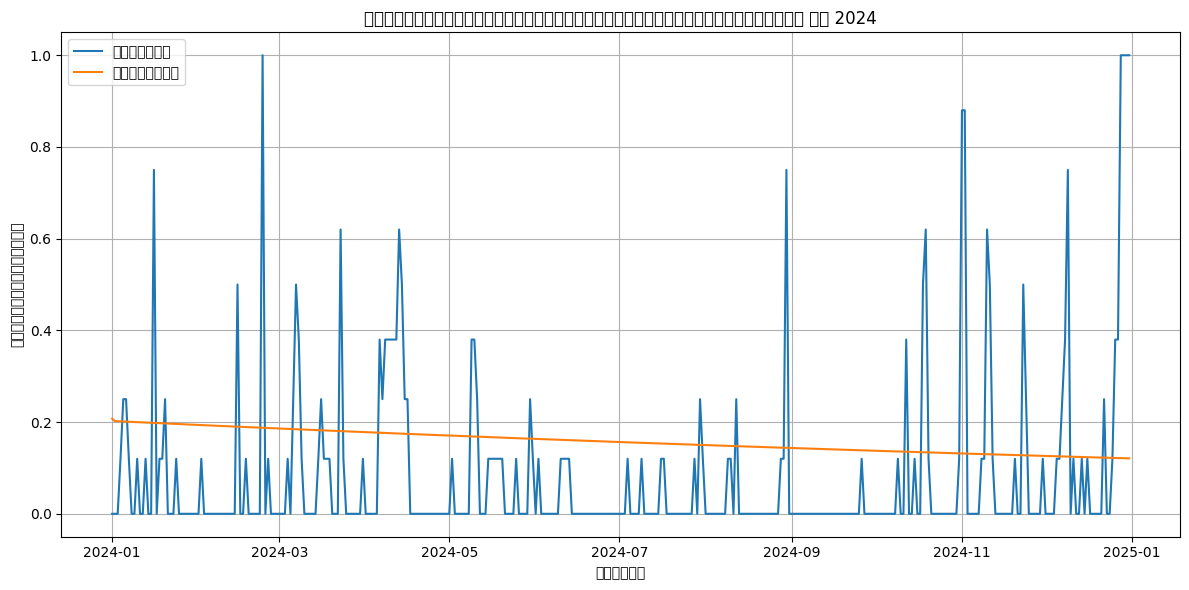


การปรับปรุงโมเดลเพื่อลด MAPE:
คำแนะนำในการปรับปรุงโมเดล:
1. ลองปรับ hyperparameters เพิ่มเติม
2. พิจารณาเพิ่ม external features เช่น วันหยุด เทศกาล
3. ตรวจสอบและจัดการกับ outliers
4. พิจารณาใช้โมเดลอื่นเช่น Prophet หรือ LSTM

บันทึกผลการทำนายลงไฟล์ 'forecast_results_2024.csv' เรียบร้อยแล้ว


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# อ่านข้อมูล
train_df = pd.read_csv('2022-2023_booking.csv')
test_df = pd.read_csv('test_data_2024.csv')
train_df.drop('booking', axis=1, inplace=True)
test_df.drop('booking', axis=1, inplace=True)

train_df = train_df.drop_duplicates(subset=['ds'])
test_df = test_df.drop_duplicates(subset=['ds'])


train_df['ds'] = pd.to_datetime(train_df['ds'], format='%d/%m/%Y')
test_df['ds'] = pd.to_datetime(test_df['ds'], format='%d/%m/%Y')

# ตรวจสอบและเตรียมข้อมูล
print("ข้อมูลฝึกฝน:")
print(train_df.head())
print("\nข้อมูลทดสอบ:")
print(test_df.head())

# สมมติว่ามีคอลัมน์วันที่และอัตราการเข้าพัก
# ตัวอย่าง: 'date' และ 'occupancy_rate'
# ปรับตามโครงสร้างข้อมูลจริง
date_column = 'ds'  # ปรับตามชื่อคอลัมน์จริง
target_column = 'y'  # ปรับตามชื่อคอลัมน์จริง

# แปลงคอลัมน์วันที่เป็น datetime
train_df[date_column] = pd.to_datetime(train_df[date_column])
test_df[date_column] = pd.to_datetime(test_df[date_column])

# ตั้งค่า index เป็นวันที่
train_df.set_index(date_column, inplace=True)
test_df.set_index(date_column, inplace=True)

# เรียงข้อมูลตามวันที่
train_df = train_df.sort_index()
test_df = test_df.sort_index()

# ตรวจสอบความถี่ของข้อมูล
print(f"\nความถี่ของข้อมูลฝึกฝน: {train_df.index.inferred_freq}")

# หาค่าพารามิเตอร์ที่เหมาะสมสำหรับ SARIMAX
# ในที่นี้เราจะทดลองหลายค่า
best_mape = float('inf')
best_model = None
best_order = None
best_seasonal_order = None

# ฟังก์ชันคำนวณ MAPE
def calculate_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# GridSearch for optimal parameters
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = [0]
Q_values = range(0, 2)
s_values = [7, 12, 30]  # สำหรับข้อมูลรายวัน, รายเดือน หรือรายสัปดาห์

for s in s_values:
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                order = (p, d, q)
                                seasonal_order = (P, D, Q, s)
                                
                                # สร้างและฝึกฝนโมเดล
                                model = SARIMAX(
                                    train_df[target_column],
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                model_fit = model.fit(disp=False, maxiter=200)
                                
                                # ทำนายค่า
                                forecast = model_fit.forecast(steps=len(test_df))
                                
                                # คำนวณ MAPE
                                mape = calculate_mape(test_df[target_column].values, forecast)
                                
                                # ตรวจสอบว่าดีกว่าโมเดลที่ดีที่สุดปัจจุบันหรือไม่
                                if mape < best_mape:
                                    best_mape = mape
                                    best_model = model_fit
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                                    
                                print(f"SARIMAX{order}x{seasonal_order} - MAPE: {mape:.2f}%")
                                
                            except Exception as e:
                                continue

print(f"\nโมเดลที่ดีที่สุด: SARIMAX{best_order}x{best_seasonal_order}")
print(f"MAPE ที่ดีที่สุด: {best_mape:.2f}%")

# ใช้โมเดลที่ดีที่สุดในการทำนาย
forecast = best_model.forecast(steps=len(test_df))

# คำนวณเมทริกซ์การประเมินผล
mae = mean_absolute_error(test_df[target_column], forecast)
mape = calculate_mape(test_df[target_column].values, forecast)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# สร้างกราฟเปรียบเทียบค่าจริงและค่าทำนาย
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df[target_column], label='ค่าจริง')
plt.plot(test_df.index, forecast, label='ค่าทำนาย')
plt.title('การเปรียบเทียบอัตราการเข้าพักจริงและค่าทำนาย ปี 2024')
plt.xlabel('วันที่')
plt.ylabel('อัตราการเข้าพัก')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if mape > 20:
    print("\nการปรับปรุงโมเดลเพื่อลด MAPE:")
    
    # ลองใช้วิธีปรับแต่งข้อมูล
    # 1. ตรวจสอบและจัดการกับ outliers
    # 2. เพิ่ม external features เช่น วันหยุดนักขัตฤกษ์ เทศกาล
    
    # ตัวอย่างการเพิ่ม external features (สมมติว่ามีคอลัมน์ 'is_holiday')
    if 'is_holiday' in train_df.columns and 'is_holiday' in test_df.columns:
        # ใช้ exog ในการสร้างโมเดล
        model = SARIMAX(
            train_df[target_column],
            exog=train_df[['is_holiday']],
            order=best_order,
            seasonal_order=best_seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        
        # ทำนายด้วย exog
        forecast_exog = model_fit.forecast(
            steps=len(test_df),
            exog=test_df[['is_holiday']]
        )
        
        # คำนวณเมทริกซ์การประเมินผลใหม่
        mae_exog = mean_absolute_error(test_df[target_column], forecast_exog)
        mape_exog = calculate_mape(test_df[target_column].values, forecast_exog)
        
        print(f"MAE ด้วย external features: {mae_exog:.4f}")
        print(f"MAPE ด้วย external features: {mape_exog:.2f}%")
        
        # สร้างกราฟเปรียบเทียบใหม่
        plt.figure(figsize=(12, 6))
        plt.plot(test_df.index, test_df[target_column], label='ค่าจริง')
        plt.plot(test_df.index, forecast_exog, label='ค่าทำนายด้วย external features')
        plt.title('การเปรียบเทียบอัตราการเข้าพักจริงและค่าทำนายปรับปรุง ปี 2024')
        plt.xlabel('วันที่')
        plt.ylabel('อัตราการเข้าพัก')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        # แนะนำวิธีการปรับปรุงเพิ่มเติม
        print("คำแนะนำในการปรับปรุงโมเดล:")
        print("1. ลองปรับ hyperparameters เพิ่มเติม")
        print("2. พิจารณาเพิ่ม external features เช่น วันหยุด เทศกาล")
        print("3. ตรวจสอบและจัดการกับ outliers")
        print("4. พิจารณาใช้โมเดลอื่นเช่น Prophet หรือ LSTM")
else:
    print("\nโมเดลมีประสิทธิภาพดี (MAPE < 20%)")

# สร้างข้อมูลการทำนายเป็นไฟล์ CSV
forecast_df = pd.DataFrame({
    'date': test_df.index,
    'actual': test_df[target_column],
    'forecast': forecast,
    'error': test_df[target_column] - forecast,
    'abs_error': abs(test_df[target_column] - forecast),
    'percentage_error': abs((test_df[target_column] - forecast) / test_df[target_column]) * 100
})

forecast_df.to_csv('forecast_results_2024.csv')
print("\nบันทึกผลการทำนายลงไฟล์ 'forecast_results_2024.csv' เรียบร้อยแล้ว")